# Question Answering System for COVID-19 Research Dataset
                           


In [1]:
# import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pprint import pprint
from gensim.summarization import summarize, keywords
sns.set_style("darkgrid")

In [2]:
#Reading dataset for Covid-19. 
def read_dataset():
    df = pd.read_csv("biorxiv_clean.csv")
    df["complete_text"] = df["title"].astype(str) + df["abstract"].astype(str) + df["text"].astype(str)
    return df

In [3]:
def initial_clean(text):
    """
    Function to clean text to remove any punctuations and standardize the case to lower case
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text


def apply_all(text):
    """
    This function applies all the functions above into one for text
    """
    return stem_words(remove_stop_words(initial_clean(text)))

def apply_for_query(text):
    """
    This function applies all the functions above into one for query
    
    """
    init = initial_clean(text)
    stop = remove_stop_words(init)
    return stop

In [4]:
# This function is called by the function "print_relevant_docs" to provide the highlighted text
from termcolor import colored
def highlight_text(text,words_to_highlight):
    tot_highlight = len(words_to_highlight)    
    temp = ''    
    for t in text.split():        
        for i in range(tot_highlight): 
            if t.lower().find(words_to_highlight[i]) == 0:
                temp += ' ' + colored(t, 'white', 'on_red')                
                break
            if i == tot_highlight-1:
                temp += ' '+ t            
    return temp 

# Gets the first five top most relevant documents based on similarity ranking.

def get_relevant_docs(corpus,query): 
    sims = TFIDF_similarity(corpus,query)
    sims_docno = [item[0] for item in sims[:5]]
    sims = [row for row in sims if row[1]!=0 ]
    sims = [item[0] for item in sims[:5]]
    return sims

#Prints the relevant documents highlighting the keywords in the query with color backgraound
           
def print_relevant_docs(df,corpus,query):    
    sims = get_relevant_docs(corpus,query)    
    for sim in sims:
        text = df.iloc[sim].complete_text
        highlight = apply_for_query(query)
        print(highlight)
        print("Document Number : ", sim)
        print("\n")
        print(highlight_text(text,highlight))
        print("\n")     

In [5]:
#Extract similar articles for the query using TFIDF model
def TFIDF_similarity(corpus, query):
    tfidf = TfidfModel(corpus) 
    corpus_tfidf = tfidf[corpus]
    index = similarities.MatrixSimilarity(tfidf[corpus_tfidf])
    query_clean = apply_all(query)    
    query_bow = dictionary.doc2bow(query_clean)
    query_tfidf = tfidf[query_bow]
    sims = index[query_tfidf]
    sort_sims = sorted(enumerate(sims), key=lambda item: -item[1])
    return list(sort_sims) 

In [6]:
# Function to check the presence of the query tokens in the given sentence
def check_presence(sentence, words):
    st = sentence.lower().split() 
    k = [ w for w in words if w in st]
    if len(k) > 0:
        return True
    else:
        return False   

# Extract sentences containing the query tokens in the given document
def extract_sentences_with_query_words(df,record,query):
    key_words = apply_for_query(query)
    in_text = df.iloc[record].complete_text
    out_text = nltk.sent_tokenize(in_text)
    result = []
    for sent in out_text:
        if check_presence(sent,key_words):
            t = re.sub(r"\n", " ", sent)
            result.append(t)
    s = ' '.join(result)
    return s   
    
# Summarization of text from theanswers to the query
def answer_summarize(df,docs, query):  
    text = ''
    for i in range(len(docs)):
        query_sent = extract_sentences_with_query_words(df,docs[i],query)
        text += query_sent
    word_length = len(nltk.word_tokenize(text))
    sentences_length = len(nltk.sent_tokenize(text))
    if sentences_length > 1 and word_length > 250:
        summary = summarize(text,word_count = 250)  
        return summary
    else:
        return text
    
def answer_random_query(df,query_df,corpus):
    qnumber = np.random.randint(0,query_df.shape[0]-1)
    query = query_df.iloc[qnumber]['question']
    print(f'Query Number : {qnumber} \n Query Description : {query}')
    print('\n\n')
    sims = get_relevant_docs(corpus,query)
    summary = answer_summarize(df,sims,query)
    return summary

In [7]:
# Read questions from file
def read_questions_into_dataframe():
    # Open a file: file
    file = open('covid_questions.txt',mode='r',encoding="utf8" )
    word_data = file.readlines()
    file.close()   
    word_data = [k[:-1] for k in word_data]    
    query_df = pd.DataFrame(word_data,columns=['question'])
    query_df['query_tokens'] = query_df['question'].apply(apply_for_query).apply(set)
    return query_df


In [8]:
# Plot performance metrics. 
def plot_perf_metrics(query_df):
    import matplotlib.pyplot as plt
    %matplotlib inline
    x = query_df.ratio
    plt.hist(x, bins=10)
    score = f'Average Score : {query_df.ratio.mean():.2f}'
    plt.xlabel("Matching score between 0 to 1")
    plt.ylabel("No. of queries matched")
    plt.title('Macthing Score Vs Queries matched (50 queries used)')
    plt.text(0.5,13,score, fontsize=15)
    plt.show()    

#Reading performance metrics. Please let generate = False always unless we require to create performance metrics
# from scratch that takes a lot of time
def read_perf_metrics(data_df, corpus,query_df, generate = False):
    if  not generate:
        query_df = pd.read_csv("perf_metrics.csv")
    else:
        query_df = update_answers_to_questions(data_df, corpus,query_df)      
    return query_df

# Generate performance metrics. It takes lot of time. Unless otherwise needed advised to not to call this function
def generate_perf_metrics(data_df,corpus,query_df):
    query_df = update_answers_to_questions(data_df, corpus, query_df)
    return query_df

# Find the the query tokens present in the answer
def get_query_tokens_in_answer(answer, query):
    key_words = apply_for_query(query)
    ans_tokens = nltk.sent_tokenize(answer)
    tokens = ''
    for sent in ans_tokens:
        st_low = sent.lower().split()
        k = [ w for w in key_words if w in st_low]
        k = ' '.join(k)
        tokens = tokens +' '+ k
    tokens = set(nltk.word_tokenize(tokens))
    return tokens  


# Update  - answer description, answer tokens and the ratio meetric(also called score)
def update_answers_to_questions(data_df, corpus,query_df):
    ans_tokens = []
    ans_desc = []
    for i in range(query_df.shape[0]):
        print('Query number : ',i)
        query = query_df.iloc[i]['question']
        sims = get_relevant_docs(corpus,query)
        summary = answer_summarize(data_df,sims,query)
        tokens = get_query_tokens_in_answer(summary, query)
        ans_tokens.append(tokens)
        ans_desc.append(summary)
    query_df["answer_desc"] = pd.Series(ans_desc)
    query_df["answer_tokens"] = pd.Series(ans_tokens)
    query_df['ratio'] = query_df['answer_tokens'].apply(len)/query_df['query_tokens'].apply(len)
    return query_df  

In [9]:
# Preprocesses the dataset and creates dictionary and corpus for the dataset
def pre_process_data(df):
    # clean text and title and create new column "tokenized"
    df['tokenized'] = df['complete_text'].apply(apply_all)
    
    # first get a list of all words
    all_words = [word for item in list(df['tokenized']) for word in item]
    # use nltk fdist to get a frequency distribution of all words
    fdist = FreqDist(all_words)

    # only keep articles with more than 10 tokens, otherwise too short
    df = df[df['tokenized'].map(len) >= 10]
    # make sure all tokenized items are lists
    df = df[df['tokenized'].map(type) == list]
    df.reset_index(drop=True,inplace=True)
    
    #Generate Dictionary and Corpus for the given dataset
    dictionary = Dictionary(df["tokenized"])  # fit dictionary
    corpus = [dictionary.doc2bow(line) for line in df["tokenized"]] 
    return dictionary,corpus


In [10]:
# Reads queries from the console and exits when "quit" is entered in the Query dialog box
def enter_query(df,corpus):
    while True:
        print("Enter the query (To exit please enter 'quit') :")
        query = input()
        #if query == 'quit':
        #    break    
        sims = get_relevant_docs(corpus,query)
        print('\n\n')        
        print(answer_summarize(df,sims,query))
        print('\n\n')
        

In [11]:
# Reads queries from the console
def enter_query(df,corpus):
    print("Enter the query :")
    query = input()
    sims = get_relevant_docs(corpus,query)
    return answer_summarize(df,sims,query)


In [12]:
# Prints the answer for the random question selected from questions database       
def answer_random_query(df,query_df,corpus):
    qnumber = np.random.randint(0,query_df.shape[0]-1)
    query = query_df.iloc[qnumber]['question']
    print(f'Query Number : {qnumber} \n Query Description : {query}')
    print('\n\n')
    sims = get_relevant_docs(corpus,query)
    summary = answer_summarize(df,sims,query)
    return summary

In [13]:
# Function that displays menu for user to select the function to run
def run_menu(data_df, corpus,query_df):
    quit = False
    while not quit:
        print("Please select the number below to run the function you want :\n\n")
        print('1 ------------ Enter query to get answer')
        print('2 ------------ Generate random question with answer')
        print('3 ------------ Plot performance metrics')
        print('4 ------------ Exit from the session')
        ch = input()
        if ch[0].isnumeric():
            val = int(ch[0])
            if val == 1:
                print(enter_query(data_df,corpus))
                print("\n\nPlease press any key to continue :")
                txt = input()
                continue
            elif val == 2:
                print(answer_random_query(data_df,query_df,corpus))
                print("\n\nPlease press any key to continue :")
                txt = input()
                continue
            elif val == 3:
                qf = read_perf_metrics(data_df, corpus,query_df)
                plot_perf_metrics(qf)
                print("\n\nPlease press any key to continue :")
                txt = input()
                continue
            else:
                if val == 4:
                    quit = True
                else:
                    print("Entered number is not valid")
        else:
            print("Invalid entry")

In [14]:
data_df = read_dataset()
query_df = read_questions_into_dataframe()
dictionary, corpus = pre_process_data(data_df)

Please select the number below to run the function you want :


1 ------------ Enter query to get answer
2 ------------ Generate random question with answer
3 ------------ Plot performance metrics
4 ------------ Exit from the session
1
Enter the query :
Are pregnant women more prone to COVID-19?
Compared with the general population, in which 5.0% who were admitted to the ICU, 2.3% who needed mechanical ventilation, and 1.4% who died 12 , it seems that the severity and mortality rate of Covid-19 in pregnant women are lower.The risk of perinatal transmission of SARS-CoV-2 was low, as only one out of 26 newborns was confirmed to have a SARS-CoV-2 infection.
Study selection criteria  Studies were selected based on the inclusion and exclusion criteria outlined below-  Inclusion criteria  Studies included if they reported COVID-19 infection among pregnant women and the following: symptoms of the infection, treatment given, and outcome of pregnancy (if the delivery had occurred).
All symptoms

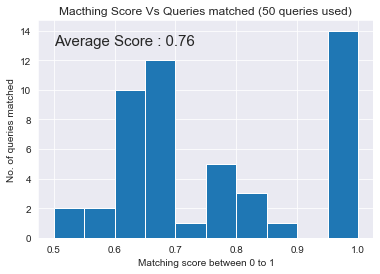



Please press any key to continue :


In [ ]:
run_menu(data_df, corpus,query_df)